# Image Recognition - CNN

In [1]:
import tensorflow as tf
from tensorflow import keras as keras
import matplotlib.pyplot as plt

2021-12-30 10:31:01.602322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-30 10:31:01.602371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

# Print data path
print("cd", data_dir)

cd /home/alexandrugris/.keras/datasets/flower_photos


In [3]:
!ls /home/alexandrugris/.keras/datasets/flower_photos

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [4]:
import pathlib

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")

There are 3670 images.


In [5]:
import random
import numpy as np

file_labels = np.array([(str(p), str(p).split("/")[-2])  for p in data_dir.glob('*/*.jpg')])
unique_labels = list({str(p).split("/")[-2] for p in data_dir.glob('*/*.jpg')})

print(unique_labels)
unique_labels = tf.constant(unique_labels)

train_idx = np.array([random.randint(0, 100) < 80 for k in range(0, len(file_labels))])


train = file_labels[train_idx == True]
test = file_labels[train_idx == False]


['sunflowers', 'dandelion', 'roses', 'daisy', 'tulips']


2021-12-30 10:31:09.967841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-30 10:31:09.967968: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-30 10:31:09.968028: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu-4gb-nbg1-development-server): /proc/driver/nvidia/version does not exist
2021-12-30 10:31:09.970452: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
IMG_HEIGHT = 244
IMG_WIDTH = 244
CHANNELS = 3

def decode_img(path_label, w_plus=0, h_plus=0):

    path = path_label[0]
    label = path_label[1]

    # image
    img_bytes = tf.io.read_file(filename=path)
    img = tf.image.decode_jpeg(img_bytes, channels=CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    img = tf.image.resize(img, (IMG_WIDTH + w_plus, IMG_HEIGHT + h_plus))

    # label
    label = tf.math.equal(unique_labels, label)

    return img, label

def enrich_img(img, label):
 
    # increase the size so I can do a random crop below - 
    # image size increased in the prev decode function
    # img = tf.image.resize(img, (IMG_WIDTH + 10, IMG_HEIGHT + 10))
    img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, CHANNELS])

    img = tf.image.random_flip_left_right(img)

    # other preprocessing I can add
    img = tf.image.random_brightness(img, max_delta = 63.0 / 255.0)
    img = tf.image.random_contrast(img, lower = 0.2, upper = 1.8)

    return img, label


images_train = tf.data.Dataset.from_tensor_slices(train) \
    .shuffle(len(train)) \
    .map(decode_img, 10, 10) \
    .cache() \
    .map(enrich_img) \
    .shuffle(320) \
    .batch(32) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

images_test = tf.data.Dataset.from_tensor_slices(test).map(decode_img).batch(1).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


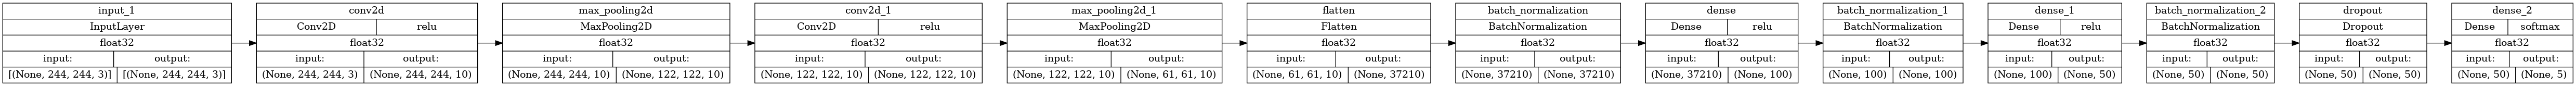

In [7]:
model_cnn = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=[IMG_WIDTH, IMG_HEIGHT, CHANNELS]),
        tf.keras.layers.Conv2D(
            filters=10, # 50 convolutions layers trained in parallel
            kernel_size=5, 
            strides=(1, 1),
            padding='same',
            activation='relu'
        ), 

        # or a MaxPooling. Recently more Conv2D layers are prefered to MaxPooling
        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2),
             padding='same'
        ),

        tf.keras.layers.Conv2D(
            filters=10, # 20 convolutions layers trained in parallel
            kernel_size=3, 
            strides=(1, 1),
            padding='same',
            activation='relu'
        ), 

        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2),
             padding='same'
        ),

        # flatten comes after the convolution layers
        tf.keras.layers.Flatten(),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=100, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=50, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(units=len(unique_labels), activation='softmax')
    ]
)

model_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics = ["categorical_accuracy"]
)

tf.keras.utils.plot_model(
    model_cnn,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


In [8]:
history = model_cnn.fit(images_train, epochs=15)

Epoch 1/15
92/92 [==============================] - 170s 2s/step - loss: 1.5513 - categorical_accuracy: 0.3721
Epoch 2/15
92/92 [==============================] - 165s 2s/step - loss: 1.3363 - categorical_accuracy: 0.4384
Epoch 3/15
92/92 [==============================] - 155s 2s/step - loss: 1.2546 - categorical_accuracy: 0.4722
Epoch 4/15
92/92 [==============================] - 149s 2s/step - loss: 1.1572 - categorical_accuracy: 0.5309
Epoch 5/15
92/92 [==============================] - 151s 2s/step - loss: 1.0995 - categorical_accuracy: 0.5480
Epoch 6/15
20/92 [=====>........................] - ETA: 1:54 - loss: 1.0385 - categorical_accuracy: 0.5781

In [ ]:
for v, l in images_test:

    v = np.argmax(model_cnn.predict(v), axis=1)
    l = np.argmax(l.numpy(), axis=1)

    print( np.sum(v == l) / len(v), 1/len(unique_labels))
    

0.3125 0.2
0.34375 0.2
0.34375 0.2
0.4375 0.2
0.59375 0.2
0.46875 0.2
0.65625 0.2
0.5 0.2
0.6875 0.2
0.71875 0.2
0.75 0.2
0.71875 0.2
0.78125 0.2
0.78125 0.2
0.53125 0.2
0.65625 0.2
0.5625 0.2
0.625 0.2
0.53125 0.2
0.5 0.2
0.53125 0.2
0.5625 0.2
0.42105263157894735 0.2


In [ ]:
model_cnn.evaluate(images_test)

23/23 [==============================] - 15s 622ms/step - loss: 1.6162 - categorical_accuracy: 0.5685


[1.6161810159683228, 0.5684647560119629]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


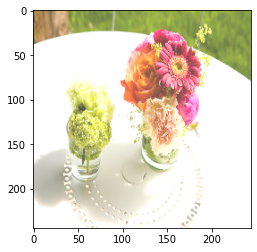

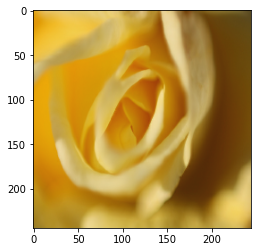

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


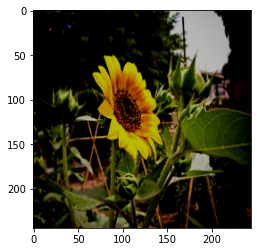

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


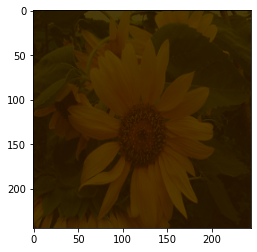

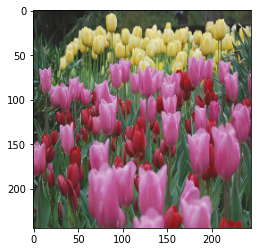

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


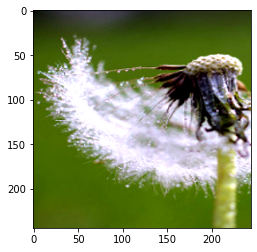

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


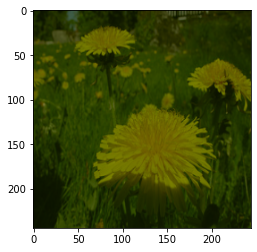

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


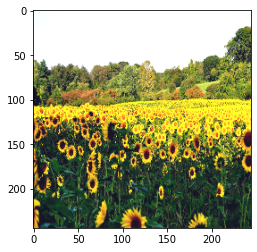

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


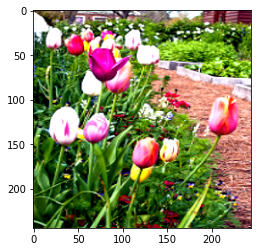

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


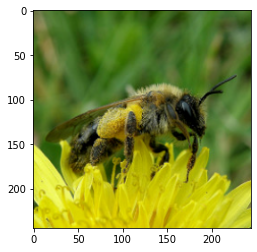

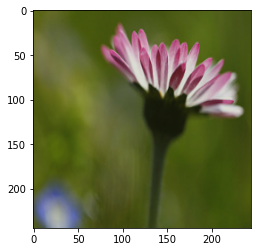

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


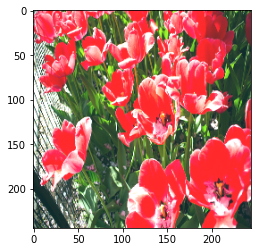

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


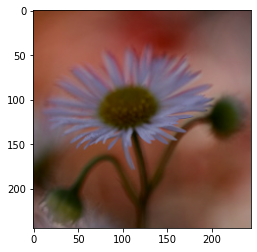

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


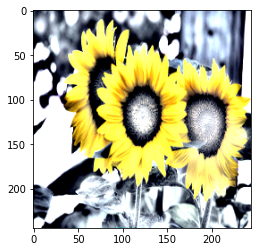

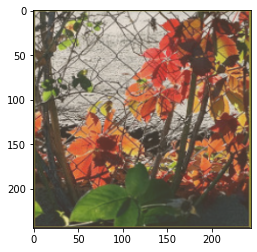

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


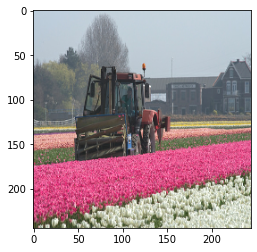

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


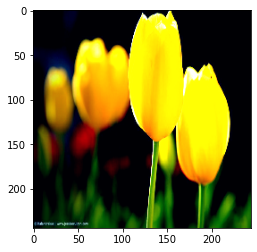

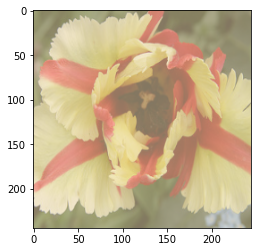

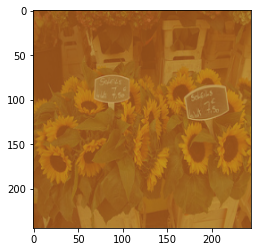

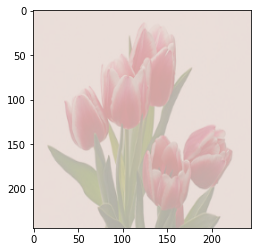

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


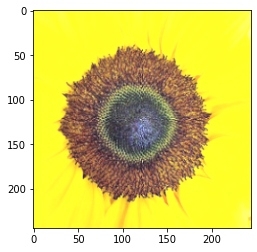

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


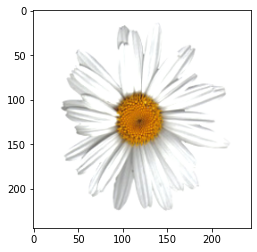

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


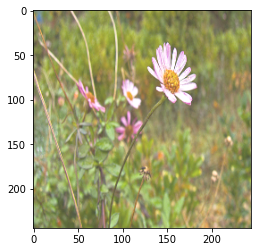

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


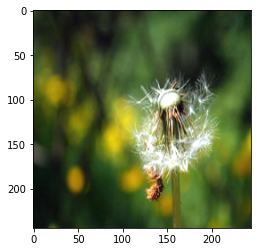

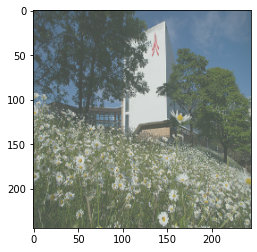

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


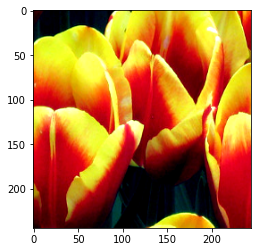

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


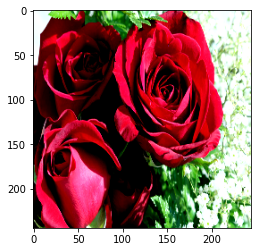

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


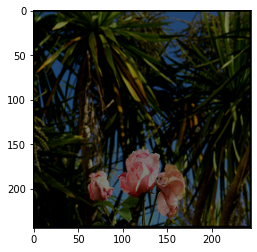

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


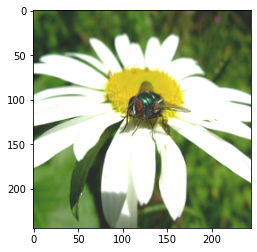

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


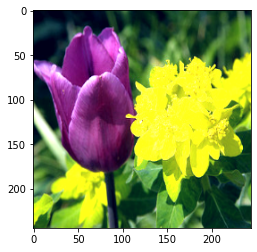

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


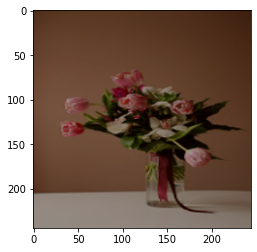

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


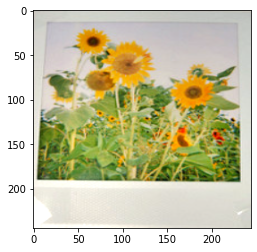

In [ ]:
img, _ = next(iter(images_train.take(1)))
for i in range(0, len(img)):
    plt.imshow(img[i].numpy())
    plt.show()

### TODO: bug ! the shuffle should be on the first array!!!!!! not in each 1000. like this most of them are roses 
### TODO: show the filter convolution how it looks after